# MS algorithm for circular-linear data

In this task, I take the data of theta as direction and the cluster is based only on the r data.
The idea of mean shift here is that, 
1. Randomly initialize a data as mean, and here we just choose the first unclusterred data.
2. Next, calculate the difference between the dataset and mean, and choose the ones that has a difference less than bandwidth.
3. Then, calculate the new mean based on the chosen data and do the second step again until the mean is smaller than the minimum distance set. 
A new random mean is draw to perform step 1 to 3 until all data is in one cluster.
We do not need to pre-define the mode number in advance, the algorithm will calculate it by itself.
However, it depends on the bandwidth that is manually defined, and in thi program, the number of bandwidth is manually tuned. There should be a better way to estimate or dynamically tune it.

In the following part, the data is process by the function defined as "meanShift".
This function takes the band width, minimum distance and data as input and output the array after clustering, the cluster result in the original sequencial and the number of mode.
The function "plot_result" is for plotting the cluster result, it's mode and print the mean and covriance of each cluster.
The last function is "pre_process" that load the data from ".csv" file and map them into [x y] format.

In [125]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [126]:
def measure(n):
    "Measurement model, return two coupled measurements."
    m1 = np.random.normal(size=n)
    m2 = np.random.normal(scale=0.5, size=n)
    return m1+m2, m1-m2

m1, m2 = measure(2000)
xmin = m1.min()
xmax = m1.max()
ymin = m2.min()
ymax = m2.max()

X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1, m2])
#print(values)
kernel = stats.gaussian_kde(values)
#print(kernel.dataset)
Z = np.reshape(kernel(positions).T, X.shape)
print(Z)

[[5.05487242e-04 6.28196861e-04 7.42172097e-04 ... 1.13525875e-51
  3.57898846e-53 1.03781140e-54]
 [6.05737306e-04 7.80292833e-04 9.46315771e-04 ... 9.30719118e-50
  3.10458928e-51 9.51930881e-53]
 [6.71039059e-04 9.01177016e-04 1.13345193e-03 ... 6.94006063e-48
  2.44854755e-49 7.93719162e-51]
 ...
 [2.39841895e-47 5.54130523e-46 1.18615932e-44 ... 2.39038780e-05
  1.27831440e-05 6.50467419e-06]
 [3.17181518e-49 7.76959885e-48 1.76829082e-46 ... 2.04377605e-05
  1.09815391e-05 5.60221891e-06]
 [3.81670931e-51 9.92250509e-50 2.40525774e-48 ... 1.76456576e-05
  9.39772288e-06 4.78247045e-06]]


In [127]:
#the functio to perform the mean shift clusttering
#input params: band_width
#              min_distance:
#              data_meanshift: the data to process, as we have a 2D data and one would have to
#                              perform as direction, the data shape here is 1D
#output result: clusterred: the reformed data after clustering
#               cluster_result: cluster result for each point in ndarray
#               current_cluster-1: the number of clusters


def meanShift(band_width, min_distance, data_meanshift):
    num_points = data_meanshift.size              # total number of points in one dataset
    cluster_flag = np.zeros(num_points)           # if each point is classified into a cluster or not, 0 refers to not clustered
    cluster_result = np.zeros(num_points)         # cluster result, for example 1 refers to cluster NO.1
    num_notclustterd = (cluster_flag == 0).sum()  # number of points not in any cluster yet
    clusterred = []


    current_cluster = 1                                # keep track of the cluster number 
    while num_notclustterd:
        index_temp = np.where(cluster_flag == 0)[0][0] # choose the first not clusterred points randomly as the mean
        current_mean = data_meanshift[index_temp]   
        diff_distance = np.Inf                         # initialize the distance different to be infinity
    
        while diff_distance > min_distance:            # stopping criteria for one cluster 
            distance_temp = data_meanshift - current_mean     # calculate the difference
            cluster_index = np.where(distance_temp < band_width)  # save the index of data that satify the criteria
            cluster_points = data_meanshift[cluster_index[0]]     # save data that satify the criteria
            #print(cluster_points)
            new_mean = np.mean(cluster_points)                    # calculate a new mean based on selected data
            #print(new_mean)
            diff_distance = np.abs(new_mean - current_mean)      # calculate the difference to the previous mean
            current_mean = new_mean
            #print(diff_distance)
        cluster_flag[cluster_index] = 1                           # set the flag to 1 to those who belong to the current
                                                                  # cluster and will not be visited again
        cluster_result[cluster_index]  = current_cluster          # set the cluster number to the data holder
        current_cluster = current_cluster + 1
        data_meanshift[cluster_index] = 1000                      # naive, set the number to be large enough so that it
                                                                  # would not be visited; using the clusterflat should 
                                                                  # make more sense
        num_notclustterd = (cluster_flag == 0).sum()              # check if all data are processed
        #print(cluster_flag)
        clusterred = [clusterred]
        
    return clusterred, cluster_result, current_cluster-1

In [128]:
# for plot
def plot_result(clusterred, cluster_result, current_cluster, data_x, data_y):
    cluster_color =["b","g","r","c","m","y","b","g","r","c","m"]
    fig = plt.figure()

    # plot different clusters
    for i in range(data_x.size):
        color_temp = cluster_color[int(cluster_result[i])-1]
        plt.plot(data_x[i], data_y[i],".",color=color_temp)

    # plot the mode for each cluster and print out mean and covariance value
    for i in range(current_cluster):

        data_x_cluster = data_x[np.where(cluster_result == i+1)]
        data_y_cluster = data_y[np.where(cluster_result == i+1)]
        data_temp=np.stack((data_x_cluster, data_y_cluster))
        mean_val = np.mean(data_temp,axis=1)
        cov_val = np.cov(data_temp)
        plt.plot(mean_val[0], mean_val[1], marker='o',markerfacecolor=cluster_color[i], markeredgecolor="k",markersize=10)
        print ("The mean value of the ", i+1, "clustter is: ", mean_val,"." )
        print ("The covariance value of the ", i+1, "clustter is: ", cov_val,"." )

In [129]:
# to pre-process the circular data into [x,y]
def pre_process(data_path):
    #read data from csv with one line of names for each col
    data_raw = np.genfromtxt(data_path,names=True, dtype=None, delimiter=',') 

    # as the dataset is circular of circular linear, we first remap it to [x y]
    data_theta = np.array(data_raw["theta"])
    data_r =  np.array(data_raw["r"])
    data_x = data_r* np.cos(data_theta)
    data_y = data_r* np.sin(data_theta)
    return data_theta, data_r, data_x, data_y

The mean value of the  1 clustter is:  [-0.78622952 -0.01037369] .
The covariance value of the  1 clustter is:  [[ 0.09377495 -0.00879855]
 [-0.00879855  0.30504982]] .
The mean value of the  2 clustter is:  [4.84509599 0.13390095] .
The covariance value of the  2 clustter is:  [[ 0.81410628 -0.145365  ]
 [-0.145365    2.63740948]] .
The mean value of the  3 clustter is:  [6.98759948 0.1380465 ] .
The covariance value of the  3 clustter is:  [[ 0.22831137 -0.03171087]
 [-0.03171087  2.61853101]] .


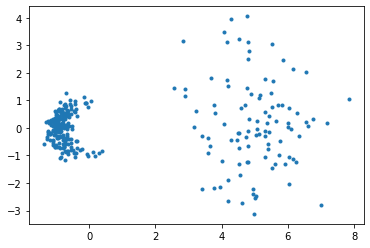

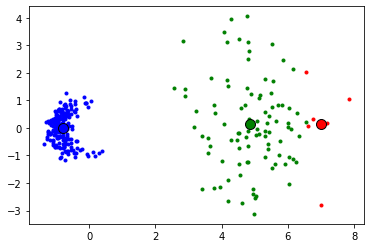

In [130]:
data_path = './data/data1.csv'
min_distance = 0.01
band_width = 1.5
[data_theta, data_r, data_x, data_y] = pre_process(data_path)

#visualize data after remapping
fig = plt.figure()
plt.plot(data_x, data_y,".")

# process and visualize
[clusterred, cluster_result, current_cluster] = meanShift(band_width, min_distance, data_r)
plot_result(clusterred, cluster_result, current_cluster, data_x, data_y)


The mean value of the  1 clustter is:  [3.09921957 2.07437343] .
The covariance value of the  1 clustter is:  [[ 0.77630374 -0.84254689]
 [-0.84254689  2.02948843]] .
The mean value of the  2 clustter is:  [5.49903107 0.18559261] .
The covariance value of the  2 clustter is:  [[ 0.29149229 -0.23558854]
 [-0.23558854  2.36983521]] .
The mean value of the  3 clustter is:  [ 6.7433964  -0.53601131] .
The covariance value of the  3 clustter is:  [[0.18728468 0.32213428]
 [0.32213428 4.55630992]] .


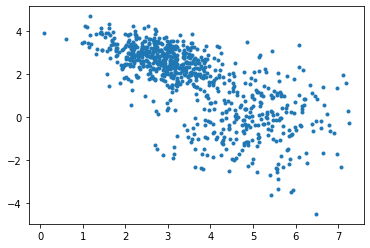

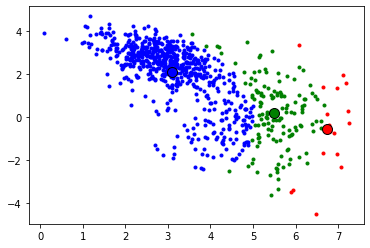

In [131]:
data_path = './data/data2.csv'
band_width = 1
[data_theta, data_r, data_x, data_y] = pre_process(data_path)

#visualize data after remapping
fig = plt.figure()
plt.plot(data_x, data_y,".")

# process and visualize
[clusterred, cluster_result, current_cluster] = meanShift(band_width, min_distance, data_r)
plot_result(clusterred, cluster_result, current_cluster, data_x, data_y)

The mean value of the  1 clustter is:  [-1.66613629  1.59808349] .
The covariance value of the  1 clustter is:  [[ 4.9100343  -1.60623006]
 [-1.60623006  2.18647159]] .
The mean value of the  2 clustter is:  [3.1543514  0.83191976] .
The covariance value of the  2 clustter is:  [[13.25288152 -5.09195641]
 [-5.09195641  4.08903679]] .
The mean value of the  3 clustter is:  [ 6.62110745 -0.10171635] .
The covariance value of the  3 clustter is:  [[0.22474723 0.01503337]
 [0.01503337 3.41252714]] .


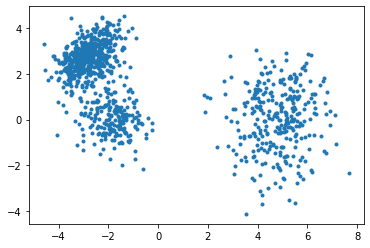

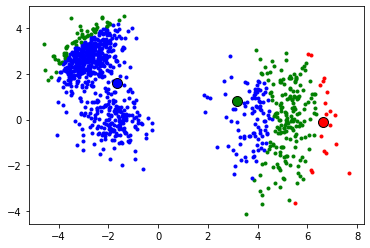

In [132]:
data_path = './data/data3.csv'
[data_theta, data_r, data_x, data_y] = pre_process(data_path)
band_width = 1.2
#visualize data after remapping
fig = plt.figure()
plt.plot(data_x, data_y,".")

# process and visualize
[clusterred, cluster_result, current_cluster] = meanShift(band_width, min_distance, data_r)
plot_result(clusterred, cluster_result, current_cluster, data_x, data_y)

The mean value of the  1 clustter is:  [ 0.27654806 -0.01010758] .
The covariance value of the  1 clustter is:  [[ 9.90654716 -0.13341212]
 [-0.13341212  0.84798305]] .
The mean value of the  2 clustter is:  [6.13740911 0.43402557] .
The covariance value of the  2 clustter is:  [[ 0.42431322 -0.22674841]
 [-0.22674841  3.88199975]] .


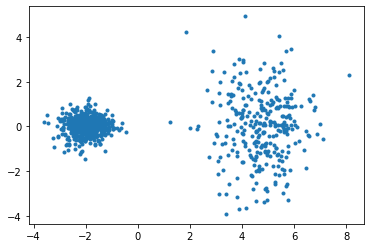

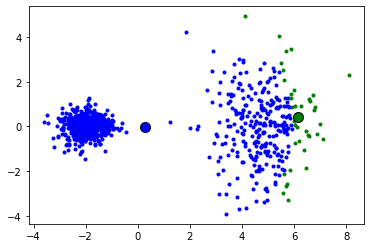

In [133]:
data_path = './data/data4.csv'
band_width = 3
[data_theta, data_r, data_x, data_y] = pre_process(data_path)

#visualize data after remapping
fig = plt.figure()
plt.plot(data_x, data_y,".")

# process and visualize
[clusterred, cluster_result, current_cluster] = meanShift(band_width, min_distance, data_r)
plot_result(clusterred, cluster_result, current_cluster, data_x, data_y)

The mean value of the  1 clustter is:  [3.23164181 1.69162243] .
The covariance value of the  1 clustter is:  [[ 0.29420742 -0.3055209 ]
 [-0.3055209   1.24321106]] .
The mean value of the  2 clustter is:  [4.24367711 1.32099938] .
The covariance value of the  2 clustter is:  [[ 0.41882992 -0.83180361]
 [-0.83180361  3.28020024]] .
The mean value of the  3 clustter is:  [ 5.56064948 -0.26452857] .
The covariance value of the  3 clustter is:  [[0.23525097 0.14797426]
 [0.14797426 2.64446548]] .
The mean value of the  4 clustter is:  [ 6.33520031 -0.45119078] .
The covariance value of the  4 clustter is:  [[0.20035758 0.18473899]
 [0.18473899 4.41574648]] .
The mean value of the  5 clustter is:  [ 7.4726589  -0.87346052] .
The covariance value of the  5 clustter is:  [[0.1129651  0.24539714]
 [0.24539714 2.74521871]] .


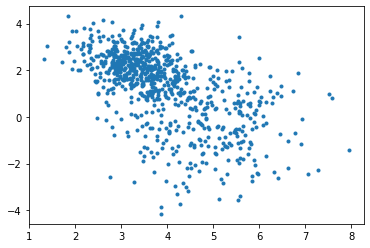

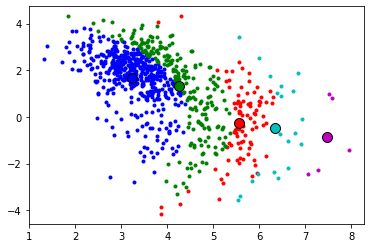

In [134]:
data_path = './data/data5.csv'
band_width = 0.6
[data_theta, data_r, data_x, data_y] = pre_process(data_path)

#visualize data after remapping
fig = plt.figure()
plt.plot(data_x, data_y,".")

# process and visualize
[clusterred, cluster_result, current_cluster] = meanShift(band_width, min_distance, data_r)
plot_result(clusterred, cluster_result, current_cluster, data_x, data_y)

The mean value of the  1 clustter is:  [1.8544436 1.2187651] .
The covariance value of the  1 clustter is:  [[ 1.15252815 -0.74748841]
 [-0.74748841  2.02037773]] .
The mean value of the  2 clustter is:  [2.80797793 1.05868803] .
The covariance value of the  2 clustter is:  [[ 1.63040149 -1.42017465]
 [-1.42017465  5.02267257]] .
The mean value of the  3 clustter is:  [4.15402558 0.38336721] .
The covariance value of the  3 clustter is:  [[ 0.61682047 -0.19835895]
 [-0.19835895  7.07217604]] .


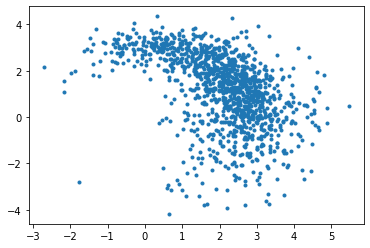

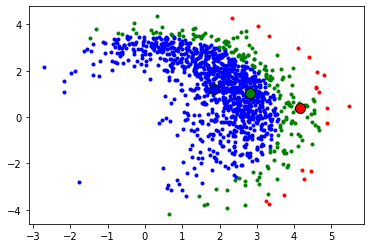

In [135]:
data_path = './data/data6.csv'
band_width = 0.8
[data_theta, data_r, data_x, data_y] = pre_process(data_path)

#visualize data after remapping
fig = plt.figure()
plt.plot(data_x, data_y,".")

# process and visualize
[clusterred, cluster_result, current_cluster] = meanShift(band_width, min_distance, data_r)
plot_result(clusterred, cluster_result, current_cluster, data_x, data_y)

The mean value of the  1 clustter is:  [0.01169898 2.43486164] .
The covariance value of the  1 clustter is:  [[ 2.11723578 -0.07404559]
 [-0.07404559  0.58011483]] .
The mean value of the  2 clustter is:  [-0.06568609  3.98044095] .
The covariance value of the  2 clustter is:  [[ 5.73663738 -0.06815426]
 [-0.06815426  1.15101721]] .
The mean value of the  3 clustter is:  [0.10731107 4.97217675] .
The covariance value of the  3 clustter is:  [[ 8.1656813  -0.24131626]
 [-0.24131626  1.17038314]] .


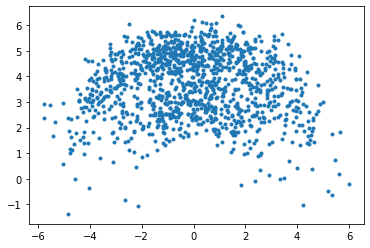

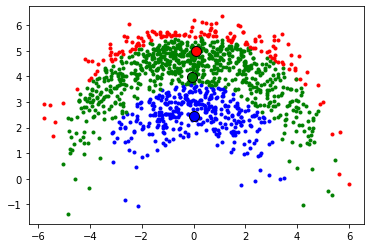

In [136]:
data_path = './data/data7.csv'
band_width = 0.8
[data_theta, data_r, data_x, data_y] = pre_process(data_path)

#visualize data after remapping
fig = plt.figure()
plt.plot(data_x, data_y,".")

# process and visualize
[clusterred, cluster_result, current_cluster] = meanShift(band_width, min_distance, data_r)
plot_result(clusterred, cluster_result, current_cluster, data_x, data_y)